In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [189]:
# NOTE: Weird bug: when cropping the .mpt files, if i open it crop and then click save as in notepad pd.read_csv will not work (says unicode character at beginning can't be decoded) but if I copy the .mpt, and then edit and save it in vs code, it works.

# 50 LMRD cycle 1 -. This is what is started with 
# path = "data_files\IK_50LMRD_cyc1_entropy\IK_50LMRD_entropy_C01_cropped.mpt"
# name = "50LMRD_cycle1"
# start_hour = 13 #inclusive
# middle_transition_hour = 174 #ignored 
# end_hour = 300 #exclusive (like we don't count this point so if we say 300, the last round of data is 293 to 300)
# mass = 0.0121884 # mass of the electrode in g
# theoretical_capacity = 378 # mAh/g

# 30 LMRD cycle 1 -> this is what ishi manually did
path = "data_files\IK_30LMRD_cyc1_2_entropy\IK_30LMRD_entropy_3_C01_cropped.mpt"
name = "30LMRD_cycle1"
start_hour = 13 
middle_transition_hour = 160
end_hour = 273
mass = 0.012676
theoretical_capacity = 342

# # 30 LMRD cycle 2
# path = "data_files\IK_30LMRD_cyc1_2_entropy\IK_30LMRD_entropy_3_C01_cropped.mpt"
# name = "30LMRD_cycle2"
# start_hour = 274
# middle_transition_hour = 379
# end_hour = 471
# mass = 0.012676
# theoretical_capacity = 342

# # 50 LMRD cycle 2
# path= "data_files\IK_50LMRD_cyc2_entropy\IK_50LMRD_entropy_cyc2_2_C01_cropped.mpt"
# name= "50LMRD_cycle2"
# start_hour= 3
# middle_transition_hour= 108
# end_hour= 207
# mass= 0.0121884
# theoretical_capacity= 378

output_path = os.path.join("scratch",name)

if not os.path.exists(output_path):
    os.makedirs(output_path)
else:
    print(f"Output directory {output_path} already exists. Overwriting files.")

data = pd.read_csv(path, sep="\t")
# print(data.head())

Output directory scratch\30LMRD_cycle1 already exists. Overwriting files.


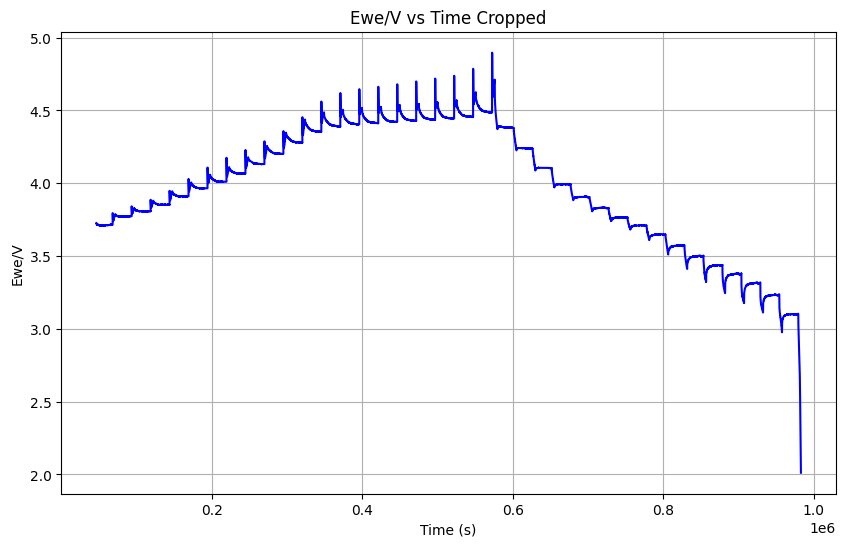

In [190]:
time = data["time/s"].to_numpy()
ewe = data["Ewe/V"].to_numpy()
capacity = data["Capacity/mA.h"].to_numpy()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(time[3600*start_hour:3600*end_hour], ewe[3600*start_hour:3600*end_hour], label='Ewe/V vs Time Cropped', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Ewe/V')
plt.title('Ewe/V vs Time Cropped')
plt.grid(True)

plt.savefig(os.path.join(output_path, 'ewe_vs_time_cropped.png'))
# Show the plot
plt.show()

# Optionally, save the plot
# plt.savefig('ewe_vs_time.png')

In [191]:
# # The difference isn't exactly one second every time! This error accumulates!
# print(time[500001]-time[500000])
# print(time[800001]-time[800000])
# print(time[1])

# print(time[500000]) # i assume this is at 500,000 seconds but its actually at 499961 seconds the sample.



In [192]:
# print(len(ewe))
# print(len(time))
# print(len(capacity))

# Downsample ewe and time to give a reading every hour
ewe_hourly = ewe[::3600]
time_hourly = time[::3600]
capacity_hourly = capacity[::3600]
time_hourly = time_hourly/3600
time_hourly = time_hourly.round()

# print(len(ewe_hourly))
# print(len(time_hourly))
# print(len(capacity_hourly))
# print(time_hourly)

#NOTE: The method above is naive and accumulates error, see below the last hour i have is 302 but I have only 301
print(time_hourly[-1])
print(time[-1])
print(len(time))
print(time[-1]/3600)
# looks like it's off by a minut fur the last one,

471.0
1695598.284285728
1695740
470.9995234127022


In [193]:
# Attempt to be more precise
time_hourly2 = []
ewe_hourly2 = []
capacity_hourly2 = []
indices_hourly = []
for ind, t in enumerate(time):
    if time[ind] == len(time_hourly2)*3600:
        time_hourly2.append(t/3600)
        ewe_hourly2.append(ewe[ind])
        capacity_hourly2.append(capacity[ind])
        indices_hourly.append(ind)
    elif time[ind] > len(time_hourly2)*3600:
        time_hourly2.append(time[ind-1]/3600)
        ewe_hourly2.append(ewe[ind-1])
        capacity_hourly2.append(capacity[ind-1])
        indices_hourly.append(ind-1)

# assuming that it ends on the hours
time_hourly2.append(time[-1]/3600)
ewe_hourly2.append(ewe[-1])
capacity_hourly2.append(capacity[-1])

In [194]:
print(time_hourly[-10:])
print(time_hourly2[-10:])
# notice how the actual hours are much closer in the second method

[462. 463. 464. 465. 466. 467. 468. 469. 470. 471.]
[461.99982717602114, 462.99981252327774, 463.9998244816072, 464.99982305106806, 465.9998216205297, 466.9998201899914, 467.9998187594539, 468.9998173289156, 469.9998026761764, 470.9995234127022]


In [195]:
time_hourly = np.array(time_hourly2).round()
ewe_hourly = np.array(ewe_hourly2)
capacity_hourly = np.array(capacity_hourly2)
indices_hourly = np.array(indices_hourly)


In [196]:
# Create a pandas dataframe that will outputted to a csv with the following headers:
# Time (h)	Peak  potential	Temperature	OCV	dE/dT	dS	Capacity (mAh)	Capacity corresponding to peak  potential (mAh/g)

# Create a dictionary with the data
times = []
peak_potential = []
temp = []
OCV = []
dE_dT = []
dS = []
capacity_peak_pot = []
cycle_temps = [45, 35, 25, 15, 5]

for v, t, c in zip(ewe_hourly, time_hourly, capacity_hourly):
    if t < start_hour or t==middle_transition_hour: 
        # ignore the first 12 hours and one hour derp in transition between charge and discharge
        #end analysis at 300 hours
        continue
    if t >=end_hour:
        break
        
    if t <middle_transition_hour:
        cycle_time_h = int((t-start_hour) % 7)
    else:
        cycle_time_h = int((t-(middle_transition_hour+1))%7) # the hour after middle transition hour, so that should be counted as zero.
    print("AT cycle time: ", cycle_time_h, "time: ", t)
    if cycle_time_h == 0:
        print("At peak potential",v,"time", t)
        times.append(t)
        peak_potential.append(v)
        temp.append(' ') # use ' ' to indicate empty cell in excel (could also use None or '')
        OCV.append(' ')
        dE_dT.append(' ')
        dS.append(' ')
        capacity_peak_pot.append(c/mass)
        if t==middle_transition_hour-7: 
            # store the capacity right before the transition from charge to discharge
            # it's used in the calculation for SOC for the discharge cycle
            capacity_at_transition = capacity_peak_pot[-1]

    # ignore hour 2 (we read only after the seconf 45C hour) for charge
    # for discharge ignore hour 6 (right now, can try adding a reading of 45c then as well)
    elif (t<middle_transition_hour and cycle_time_h >=2 and cycle_time_h <= 6) or (t>middle_transition_hour and cycle_time_h >=1 and cycle_time_h<=5): # or cycle_time_h == 0:
        times.append(' ')
        peak_potential.append(' ')
        if t<middle_transition_hour:
            # at hour 2, we want 45c, hour 3, 35c, etc.
            temp.append(cycle_temps[cycle_time_h-2])
        else:
            #at hour 1 we want 45c, hour 2, 35c, etc.
            temp.append(cycle_temps[cycle_time_h-1])
        # OCV.append(ewe[int(t)*3600-1])
        # OCV.append(v)
        OCV.append(ewe[indices_hourly[int(t)]-1])
        dE_dT.append(' ')
        dS.append(' ')
        capacity_peak_pot.append(' ')

    #find slope of line of best fit of the five points
    if cycle_time_h == 6:
        print("OCV: ", OCV[-5:])
        print("cycle temps", cycle_temps)
        m, b = np.polyfit(cycle_temps, OCV[-5:], 1)
        dE_dT[-6] = m
        dS[-6] = m*96500

condensed_times = [int(x) for x in times if x != ' ']
condensed_peak_pot = [float(x) for x in peak_potential if x != ' ']
condensed_ds = [float(x) for x in dS if x != ' ']
condensed_capacity = [float(x) for x in capacity_peak_pot if x != ' ']
soc = []
for x, t in zip(condensed_capacity, condensed_times):
    if t <= middle_transition_hour - 7:
        soc.append(float(x / theoretical_capacity * 100))
    else:
        soc.append(float((capacity_at_transition - x) / theoretical_capacity * 100))

# Pad condensed dictionaries to be the same length
length = len(times)
for d in [condensed_peak_pot, condensed_ds, condensed_capacity, soc]:
    while len(d) < length:
        d.append(None)


empty_dummy = [' ']*length

data_dict = {
    'Time (h)': times,
    'Peak potential': peak_potential,
    'Temperature': temp,
    'OCV': OCV,
    'dE/dT': dE_dT,
    'dS': dS,
    'Capacity corresponding to peak  potential (mAh/g)': capacity_peak_pot,
    ' ': empty_dummy,
    'final dS': condensed_ds,
    'Voltage': condensed_peak_pot,
    'Capacity (mAh/g)': condensed_capacity,
    '% SOC': soc
}


AT cycle time:  0 time:  13.0
At peak potential 3.7279866 time 13.0
AT cycle time:  1 time:  14.0
AT cycle time:  2 time:  15.0


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [183]:
# print the lengths of all the lists in data_dict
for key in data_dict:
    print(key, len(data_dict[key]))

Time (h) 222
Peak potential 222
Temperature 222
OCV 222
dE/dT 222
dS 222
Capacity corresponding to peak  potential (mAh/g) 222
  222
final dS 222
Voltage 222
Capacity (mAh/g) 222
% SOC 222


In [184]:
# Export to csv
df = pd.DataFrame(data_dict)
df.to_csv(os.path.join(output_path,'30LMRD_cycle1_output.csv'), index=False)

In [185]:
# Plot condensed ds on y axis and soc on x axis
print(len(condensed_ds))
print(len(soc))


222
222


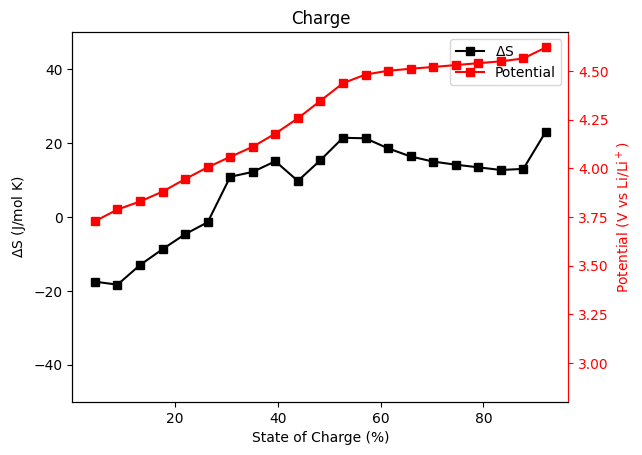

In [186]:
# separate into charge and discharge based o nmiddle transition hour
charge_soc = [s for s, t in zip(soc, condensed_times) if t <= middle_transition_hour - 7]
charge_ds = [d for d, t in zip(condensed_ds, condensed_times) if t <= middle_transition_hour - 7]
charge_pot = [p for p, t in zip(condensed_peak_pot, condensed_times) if t <= middle_transition_hour - 7]
discharge_soc = [s for s, t in zip(soc, condensed_times) if t > middle_transition_hour - 7]
discharge_ds = [d for d, t in zip(condensed_ds, condensed_times) if t > middle_transition_hour - 7]
discharge_pot = [p for p, t in zip(condensed_peak_pot, condensed_times) if t > middle_transition_hour - 7]

fig, ax1 = plt.subplots()

# Plot dS vs % SOC
ax1.plot(charge_soc, charge_ds, 's-', color='black', label='$\Delta$S')
ax1.set_xlabel('State of Charge (%)')
ax1.set_ylabel('$\Delta$S (J/mol K)')
ax1.set_title('Charge')
ax1.set_ylim(-50, 50)  # Set the y-axis limits to -50 and 50

# Create a twin y-axis on the right for peak potential
ax2 = ax1.twinx()
ax2.plot(charge_soc, charge_pot, 'rs-', label='Potential')
ax2.set_ylabel('Potential (V vs Li/Li$^+$)')
ax2.spines['right'].set_color('red')  # Set the color of the right spine to red
ax2.yaxis.label.set_color('red')  # Set the color of the right y-axis label to red
ax2.tick_params(axis='y', colors='red')  # Set the color of the right y-axis ticks and numbers to red
ax2.set_ylim(2.8, 4.7)  # Set the y-axis limits for potential

# Add the legend for both lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)

plt.savefig(os.path.join(output_path, 'charge_graph.png'))
plt.show()


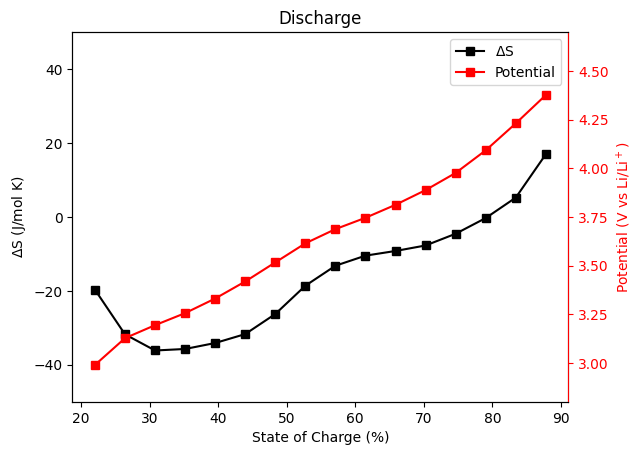

In [187]:
fig, ax1 = plt.subplots()

# Plot dS vs % SOC
ax1.plot(discharge_soc, discharge_ds, 's-', color='black', label='$\Delta$S')
ax1.set_xlabel('State of Charge (%)')
ax1.set_ylabel('$\Delta$S (J/mol K)')
ax1.set_title('Discharge')
ax1.set_ylim(-50, 50)  # Set the y-axis limits to -50 and 50

# Create a twin y-axis on the right for peak potential
ax2 = ax1.twinx()
ax2.plot(discharge_soc, discharge_pot, 'rs-', label='Potential')
ax2.set_ylabel('Potential (V vs Li/Li$^+$)')
ax2.spines['right'].set_color('red')  # Set the color of the right spine to red
ax2.yaxis.label.set_color('red')  # Set the color of the right y-axis label to red
ax2.tick_params(axis='y', colors='red')  # Set the color of the right y-axis ticks and numbers to red
ax2.set_ylim(2.8, 4.7)  # Set the y-axis limits for potential

# Add the legend for both lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)

plt.savefig(os.path.join(output_path, 'discharge_graph.png'))
plt.show()